In [4]:
#Categorizing given email is spam or ham
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

dataset = pd.read_csv('spamham.csv')
dataset.head()


,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [5]:
np.__version__

'1.22.4'

In [6]:
dataset.shape  #(5728, 2)

(5728, 2)

In [7]:
#Checking for duplicates and removing them
dataset.drop_duplicates(inplace = True)
dataset.shape  #(5695, 2)

(5695, 2)

In [8]:
#Checking for any null entries in the dataset
print (pd.DataFrame(dataset.isnull().sum()))
#Checking class distribution
dataset.groupby('spam').count()

      0
text  0
spam  0


,text
spam,
0,4327
1,1368


array([<AxesSubplot: title={'center': '0'}>,
       <AxesSubplot: title={'center': '1'}>], dtype=object)

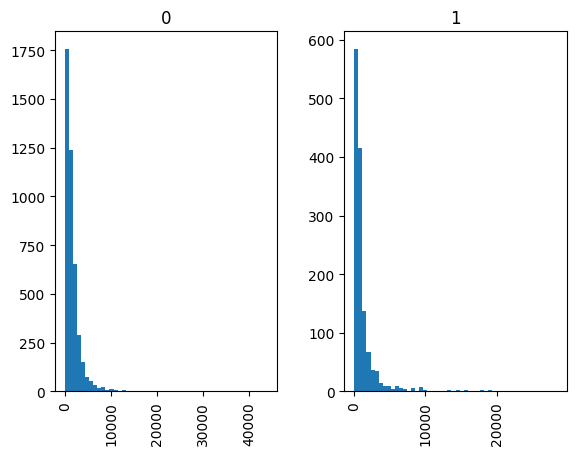

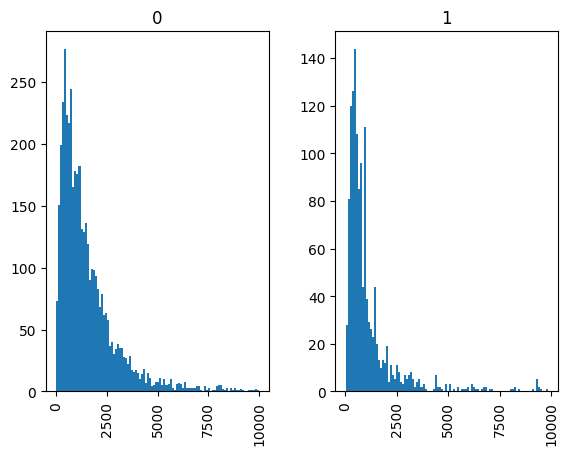

In [9]:
dataset['length'] = dataset['text'].map(lambda text: len(text))
dataset.hist(column='length', by='spam', bins=50)
#we can see some extreme outliers, we'll set a threshold for text length and plot the histogram again
dataset[dataset.length < 10000].hist(column='length', by='spam', bins=100)

## RNNs with Pre-processing in Keras

In [10]:
%%time
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

NUM_TOP_WORDS = None # use entire vocabulary!
MAX_ART_LEN = 1000 # maximum and minimum number of words

#tokenize the text
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(dataset.text)
# save as sequences with integers replacing words
sequences = tokenizer.texts_to_sequences(dataset.text)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

y_ohe = dataset.spam
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_ohe.shape)
print(np.max(X))

Found 37353 unique tokens. Distilled to 37353 top words.
Shape of data tensor: (5695, 1000)
Shape of label tensor: (5695,)
37353
Wall time: 7.51 s


So that’s it! The representation is now:
each word is converted to an integer
each article is a series of integers that represent the correct ordering of words
the target is one hot encoded

# Histogram: Distribution of y_train

X_train Shape: (4556, 1000) Label Shape: (4556,)


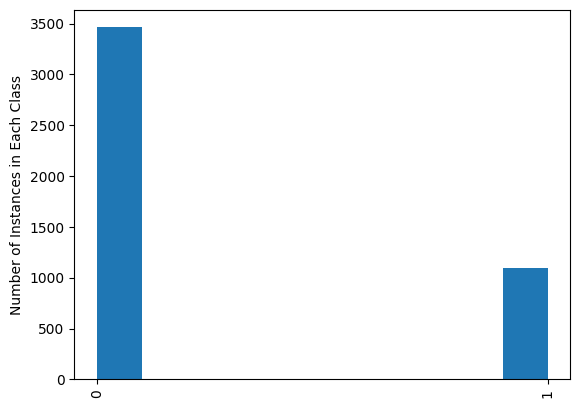

In [32]:
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt
from matplotlib import pyplot as plt
%matplotlib inline

# Split it into train / test subsets
X_train, X_test, y_train_ohe, y_test_ohe = train_test_split(X, y_ohe, test_size=0.2,
                                                            stratify=dataset.spam,
                                                            random_state=42)
NUM_CLASSES = 2

# print some stats of the data
print("X_train Shape:",X_train.shape, "Label Shape:", y_train_ohe.shape)
uniq_classes = np.sum(y_train_ohe,axis=0)
plt.hist(y_train_ohe, align='mid', stacked = 'True')
plt.xticks([0,1], np.unique(y_train_ohe), rotation='vertical', )
plt.ylabel("Number of Instances in Each Class")
plt.show()

To download the GloVe dataset:

In [38]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [33]:
import os

os.path.join(os.path.expanduser("~"), ".keras/datasets/glove.6B.100d.txt")

'C:\\Users\\ataer\\.keras/datasets/glove.6B.100d.txt'

## Creating embedding_index vector and embedding matrix
This

In [ ]:
%%time
EMBED_SIZE = 100
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('large_data/glove/glove.6B.100d.txt')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be ALL-ZEROS
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

print("Embedding Shape:",embedding_matrix.shape, "\n",
      "Total words found:",found_words, "\n",
      "Percentage:",100*found_words/embedding_matrix.shape[0])

# DENEME

In [ ]:
# show example without the FOR loop
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, SimpleRNN
from tensorflow.keras.layers import Embedding

EMBED_SIZE = 50
RNN_STATESIZE = 100
rnns = []
input_holder = Input(shape=(X_train.shape[1], ))
shared_embed = Embedding(top_words, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=500)(input_holder) # number of words in each sequence


x = SimpleRNN(RNN_STATESIZE, dropout=0.2, recurrent_dropout=0.2)(shared_embed)
x = Dense(NUM_CLASSES, activation='sigmoid')(x)
simple_rnn_model = Model(inputs=input_holder,outputs=x)


In [ ]:
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# create LSTM
x = LSTM(RNN_STATESIZE, dropout=0.2, recurrent_dropout=0.2)(shared_embed)
x = Dense(NUM_CLASSES, activation='sigmoid')(x)
lstm_model = Model(inputs=input_holder,outputs=x)

# create LSTM
x = GRU(RNN_STATESIZE, dropout=0.2, recurrent_dropout=0.2)(shared_embed)
x = Dense(NUM_CLASSES, activation='sigmoid')(x)
gru_model = Model(inputs=input_holder,outputs=x)

# lr_schedule = ExponentialDecay(
#     initial_learning_rate=0.1,
#     decay_steps=10000,
#     decay_rate=0.95)

opt = Adam(lr=0.0001, epsilon=0.0001, clipnorm=1.0)

simple_rnn_model.compile(loss='binary_crossentropy',
              optimizer= opt,
              metrics=['accuracy'])

lstm_model.compile(loss='binary_crossentropy',
              optimizer= opt,
              metrics=['accuracy'])

gru_model.compile(loss='binary_crossentropy',
              optimizer= opt,
              metrics=['accuracy'])

print(simple_rnn_model.summary())
print(lstm_model.summary())
print(gru_model.summary())
